<a href="https://colab.research.google.com/github/gabriellaaileen/ADL/blob/main/UTS%20ADL/UTS_ADL_XNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2

#import Keras sub-modules
from keras.models import Model #functional API for Keras (best for greater flexibility)
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense #'main' layers
from keras.layers import BatchNormalization, Dropout #regulartisation layers
from keras.layers import Activation
from keras.optimizers import * #import all optimisers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger #callbacks for model performance analysis
from keras.metrics import categorical_accuracy #metrics for model performance
from keras import backend as K #gives backend functionality
from keras import losses #imports pre-defined loss functions
from keras.models import load_model #allows pre-trained models to be called back

##**PREDIKSI DENGAN DATA BAWAAN (MODEL AWAL)**

In [2]:
#Download trained model dan data testing bawaan

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1Wel_XsyE7HcEq0TkZWI61GABO4jOtj9C',
                                    dest_path='./dataset.hdf5')
gdd.download_file_from_google_drive(file_id='1cePD5E-T9mr5W0xPGuzEnUt8Glpvn23U',
                                    dest_path='./model.h5')

In [3]:
hdf5_path = "./dataset.hdf5" ## this is our h5 file containing training and testing data
dataset = h5py.File(hdf5_path , 'r')

classes = 3
test_images = dataset['test_img'][:]
print(test_images.shape)
no_images, height, width, channels = test_images.shape

test_labels =dataset['test_label'][:].reshape(-1,height*width, classes )
print(test_labels.shape)
dataset.close()

(22, 200, 200, 1)
(22, 40000, 3)


In [93]:
#Load model dari file model.h5

model = load_model("/content/model.h5")

In [5]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 200, 200, 64  256        ['conv2d_1[0][0]']               
 rmalization)                   )                                                           

**Modifikasi Program**

* Mengubah dari batch ukuran 1 menjadi custom (ukuran batch tidak boleh lebih dari 22)

masukkan batch size: 5
Berikut adalah data test yang digunakan: 


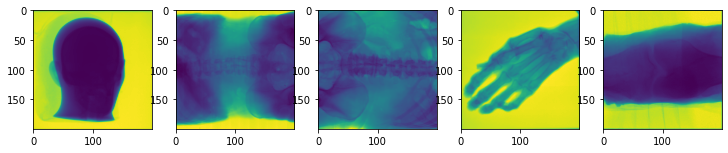

In [91]:
#Menampilkan testing images dalam batch

batch_size=int(input("masukkan batch size: "))
if batch_size > 22:
  print("maaf, ukuran batch melebihi ukuran dataset")
else:
  fig = plt.figure(figsize=(20, 20))
  print("Berikut adalah data test yang digunakan: ")
  for i in range(batch_size):
    fig.add_subplot(3, 8, i+1)
    plt.imshow(test_images[i].reshape(200,200))

* Menampilkan hasil prediksi dalam batch custom

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


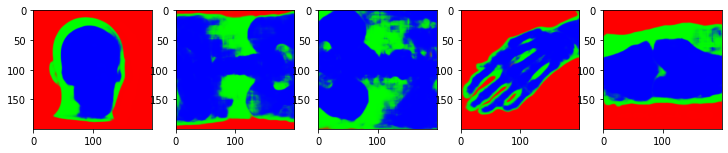

In [94]:
if batch_size > 22:
  print("maaf, ukuran batch melebihi ukuran dataset")
else:
  testing_image=np.empty([batch_size,200,200,1])
  for i in range(batch_size):
    testing_image[i]=test_images[i]
  testing_image=testing_image.reshape((batch_size,200,200,1))
  
  prediction2 = model.predict(testing_image)
  prediction2 = prediction2.reshape((batch_size,200,200,3))

  fig = plt.figure(figsize=(20, 20))
  for i in range(batch_size):
    fig.add_subplot(3, 8, i+1)
    plt.imshow(prediction2[i])

##**PREDIKSI DENGAN DATA DARI KAGGLE (MODEL AWAL)**

**Load data dari Kaggle**

Data yang digunakan adalah data gambar X-Ray RSNA Bone Age yang merupakan X-Ray telapak tangan

In [8]:
!pip install kaggle

In [9]:
#Upload file json kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mendrofaa","key":"71cbe0b6310e6e2134984f289b929c1f"}'}

In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [03:39<00:00, 55.0MB/s]
100% 9.29G/9.29G [03:40<00:00, 45.3MB/s]


In [12]:
!ls

dataset.hdf5  kaggle.json  model.h5  rsna-bone-age.zip	sample_data


In [13]:
import zipfile
zip_ref = zipfile.ZipFile('rsna-bone-age.zip', 'r')
zip_ref.extractall('bone_age')
zip_ref.close()

**Preprocessing Data**
1. Mengecek ukuran dan mode gambar (RGB atau Grayscale)
2. Meresize gambar sesuai ukuran input layer (200x200)
3. Mengubah gambar menjadi format array sebagai input
4. Mereshape array menjadi (200, 200, 1)

**Contoh Preprocessing dan Prediksi 1 Data**

In [14]:
!pip install Pillow

In [15]:
# check Pillow version number
import PIL
# load and show an image with Pillow
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [16]:
# load the image
image = Image.open('/content/bone_age/boneage-training-dataset/boneage-training-dataset/10000.png')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

PNG
L
(1334, 1653)


Data masih dalam format PNG dengan mode grayscale dan berukuran (1334 x 1653). Oleh karena itu, data perlu diresize ke ukuran (200 x 200) sebelum diubah menjadi array input.

In [17]:
gs_image = image.resize((200,200))
# save in jpeg format
gs_image.save('10000_gs.png')
# load the image again and show it
image2 = Image.open('10000_gs.png')
# show the image
image2.show()

In [18]:
from matplotlib import image
from matplotlib import pyplot

float32
(200, 200)


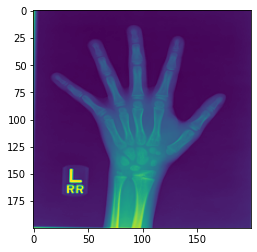

In [19]:
# load image as pixel array
data2 = image.imread('10000_gs.png')
# summarize shape of the pixel array
print(data2.dtype)
print(data2.shape)
# display the array of pixels as an image
pyplot.imshow(data2)
pyplot.show()

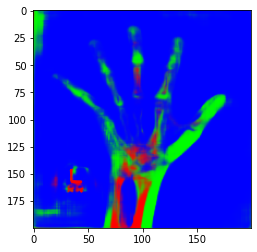

In [20]:
testing_image = data2.reshape((1,200,200,1))
prediction = model.predict(testing_image)

#the prediction is a flattened array and so must be reshaped.
#there are 3 channels as we are actually outputting the probability map over all 3 classes.
prediction = prediction.reshape((200,200,3))
plt.imshow(prediction)

**Preprocessing dan Prediksi Data dalam Batch**

In [21]:
#setting the path to the directory containing the pics
image_path = '/content/bone_age/boneage-test-dataset/boneage-test-dataset'

In [22]:
name = os.listdir(image_path)

In [23]:
batch_size2=int(input("Masukkan batch size: "))

Masukkan batch size: 5


In [24]:
#Convert image menjadi input array
input_arr=[]
for img in name[0:batch_size2]:
  image = tf.keras.preprocessing.image.load_img(path=os.path.join(image_path,img),color_mode="grayscale",target_size=(200,200))
  pic = tf.keras.preprocessing.image.img_to_array(image)
  input_arr.append(pic.reshape((1,200,200,1)))

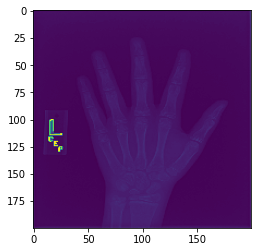

In [25]:
#Menampilkan salah satu image input 
input_arr = np.asarray(input_arr)
input_arr = input_arr.reshape(batch_size2,200,200,1)
pyplot.imshow(input_arr[0].reshape(200,200))
pyplot.show()

In [26]:
#Prediksi image dalam batch
predictions = model.predict(input_arr)

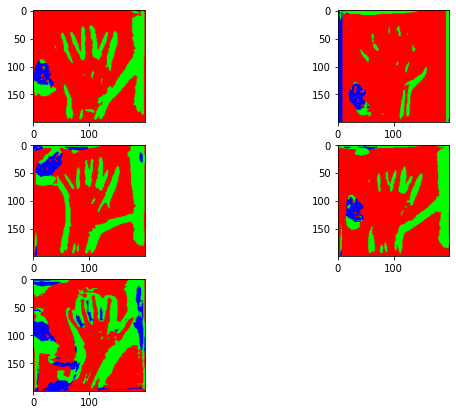

In [27]:
predictions = predictions.reshape((batch_size2,200,200,3))

fig = plt.figure(figsize=(10, 7))
for i in range(batch_size):
   fig.add_subplot(3, 2, i+1)
   plt.imshow(predictions[i])

Terlihat bahwa hasil prediksi data baru menggunakan model lama yang sudah ditraining masih kurang baik. Oleh karena itu, perlu dilakukan training model dari awal menggunakan data baru.

##**FITTING MODEL DENGAN DATASET BARU**

Data yang digunakan adalah RSNA Bone Age (boneage-test-dataset) yang didownload dari Kaggle dan dilabeli dengan tiga jenis warna, masing-masing untuk open beam, tissue, dan bone. Berikut adalah contoh data dan labelnya.

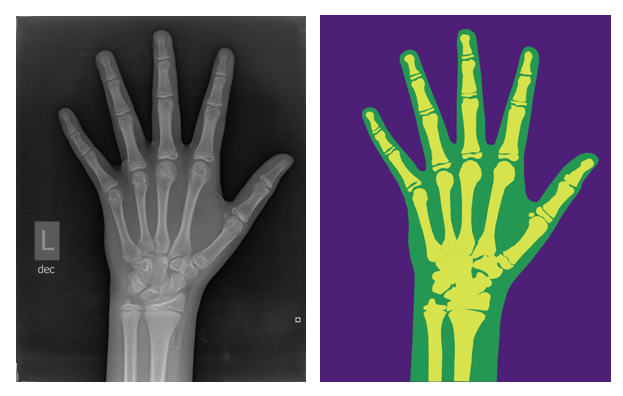

In [28]:
!pip install future

In [29]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 4.2 MB/s 


In [30]:
# A
import argparse
# C
import cv2
# G
import glob
# H
import h5py
# I
import imgaug as ia
import importlib.util
# J
import json
# M
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# N
import numpy as np
# O
import os
# P
import pandas as pd
# R
import random
import rasterio
# S
import scipy.misc
import shutil
import signal
import sys
# T
import tensorflow
import time
# W
import webbrowser

### Keras
from keras.layers import  * 
from keras.models import Model, Sequential, load_model as keras_load_model
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, TensorBoard, EarlyStopping
from keras.metrics import categorical_accuracy
from keras import backend as K
from keras import losses
from keras.optimizers import *
from keras.utils.generic_utils import get_custom_objects
### Tensor
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
### Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
### Random
from random import randint
from random import shuffle
### ImgAug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
### Others
#from _future_ import division
from IPython.display import clear_output

In [31]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

Modul dalam git ini sudah dimodifikasi dan disesuaikan untuk dataset baru. Load data dalam modul TrainingClass dan Postprocessing tidak lagi menggunakan format hdf5, tetapi langsung menggunakan gambar dengan format png dan sudah include preprocessingnya untuk menyesuaikan ukuran input XNet.

In [32]:
!git clone https://github.com/gabriellaaileen/ADL.git

Cloning into 'ADL'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (517/517), done.
remote: Total 525 (delta 234), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (525/525), 87.37 MiB | 11.28 MiB/s, done.
Resolving deltas: 100% (234/234), done.


In [33]:
%cd /content/ADL/UTS ADL

/content/ADL/UTS ADL


In [34]:
#Sebelum running program ini, hyperparameter dapat diatur dalam modul generate_parameters.py
!python3 "/content/ADL/UTS ADL/generate_parameters.py"

**Data yang digunakan dalam proses fitting dan testing adalah sebagai berikut:**
* Training data: 35 gambar pertama dalam folder data_training
* Validation data: gambar ke 36-40 dalam folder data_training
* Testing data: gambar ke 41-45 dalam folder data_training

In [47]:
!python3 "/content/ADL/UTS ADL/train.py"

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
I will train on all these parameter files:

parameters.txt
Warning, folder exists! Delete? (y/n) y
Data loaded succesfully.
/content/ADL/UTS ADL/XNet.py
2022-04-15 13:07:19.666942: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
Model loaded and compiled succesfully.
/content/ADL/UTS ADL/TrainingClass.py:300: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  

## **PREDIKSI DATA DARI KAGGLE (MODEL BARU)**

In [48]:
#Mengecek 'model_weights' dan 'optimizer_weights' dari model yang baru
filename = "/content/ADL/UTS ADL/Model0/DLs200_64.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])

Keys: <KeysViewHDF5 ['model_weights', 'optimizer_weights']>


In [49]:
#load model baru yang termuat dalam file DLs20064.h5

new_model = load_model("/content/ADL/UTS ADL/Model0/DLs200_64.h5")

In [50]:
#setting the path to the directory containing the testing pics

image_path = '/content/ADL/UTS ADL/data_training' 

In [79]:
name = sorted(os.listdir(image_path)[40:45])

In [80]:
batch_size2=int(input("Masukkan batch size: "))

Masukkan batch size: 5


In [81]:
#Preprocessing input array
input_arr=[]

for img in name[0:batch_size2]:
        data = cv2.imread(image_path+"/"+img)
        data = cv2.resize(data,(200,200))
        data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
        input_arr.append(data)

input_arr = np.asarray(input_arr)
input_arr = input_arr.reshape(batch_size2,200,200,1)

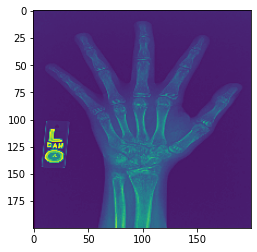

In [82]:
#Menampilkan salah satu image input 
pyplot.imshow(input_arr[0].reshape(200,200))
pyplot.show()

In [83]:
#Prediksi image dalam batch
predictions = new_model.predict(input_arr)

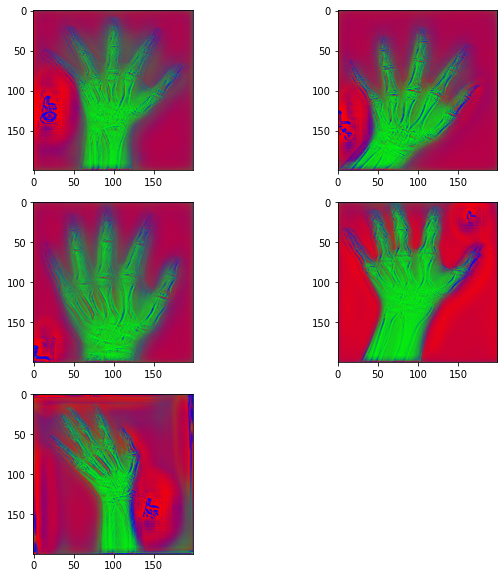

In [85]:
predictions = predictions.reshape((batch_size2,200,200,3))

fig = plt.figure(figsize=(10, 10))
for i in range(batch_size2):
   fig.add_subplot(3, 2, i+1)
   plt.imshow(predictions[i])